Project241208 JiahuiGuo Final version by VGG16

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch import tensor
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torchsummary import summary
import torchvision.models as models
import json

In [ ]:
os.getcwd()

**1.0** GPU

In [2]:
device = (
    "cuda" if torch.cuda.is_available()
     else "cpu"
)
device

'cpu'

**2.0** Data preprocessing

Only work on subset of data. Due to the memory, we have to run the code on the whole datasets by submitting batch job

In [ ]:
def LoadingData():
    xData = list() #graphs
    yData = list() #labels
    labelNameDict = dict() #dictionary
    dataPath = "/home/dl09e24/people/lilyguo/SmallSubset/" #path! SUBSETOFDATA!
    listdir = os.listdir(dataPath) #subfoldername
    
    for label,labelName in enumerate(listdir):
        labelNameDict[label] = labelName
        for filename in os.listdir(dataPath + labelName):
            if not filename.endswith('.jpg'):
                continue
            imageSize = (32,32) #can be changed to (256,256)
            x = PIL.Image.open(dataPath + labelName + '/' + filename).resize(imageSize)
            x = torch.FloatTensor(np.array(x)) /255
            #[32,32,3] -> [3,32,32]
            x = x.permute(2,0,1)
            xData.append(x)
            yData.append(label)
            
    return xData, yData, labelNameDict

In [ ]:
xData, yData, LabelNameDict = LoadingData()

In [8]:
len(xData), len(yData), xData[0].shape, yData[0], LabelNameDict

(16000,
 16000,
 torch.Size([3, 32, 32]),
 0,
 {0: 'Mud (2012)',
  1: 'The Boat That Rocked (2009)',
  2: 'JFK (1991)',
  3: 'A History of Violence (2005)',
  4: 'The Warriors (1979)',
  5: 'Foxcatcher (2014)',
  6: 'Enchanted (2007)',
  7: 'Slumdog Millionaire (2008)',
  8: 'Vicky Cristina Barcelona (2008)',
  9: 'The Equalizer (2014)',
  10: 'Searching (2018)',
  11: 'Ghandi (1982)',
  12: 'Winters Bone (2010)',
  13: 'Black Mirror Bandersnatch (2018)',
  14: 'Star Trek II The Wrath of Khan (1982)',
  15: 'As Good as It Gets (1997)',
  16: 'Straight Outta Compton (2015)',
  17: 'Highlander (1986)',
  18: 'Indiana Jones And The Temple Of Doom (1984)',
  19: 'Sing 2 (2021)'})

**3.0** train/test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xData, yData, test_size=0.4, random_state=20241127)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.20, random_state=20241127)

In [19]:
len(X_val), len(y_val), X_val[0].shape, y_val[0]

(801, 801, torch.Size([3, 32, 32]), 12)

In [ ]:
class Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.Y)
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

In [ ]:
train_dataset = Dataset(X_train,y_train)
test_dataset = Dataset(X_test, y_test)
val_dataset = Dataset(X_val, y_val)

data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)
data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

#The batch size will be adjusted to 512 for training dataset and 256 for test and validation datasets when we run it on the whole dataset 

**4.0** Neural Network

In [3]:
class VGG16Model(nn.Module):
    def __init__(self, num_classes):
        super(VGG16Model, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )
    def forward(self, x):
        x = self.vgg16(x)  
        return x

In [4]:
model = VGG16Model(num_classes=20).to(device)
# The num_classes will be adjusted to the same length of the dictionary ('labelNameDict')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
model

VGG16Model(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

In [6]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

class DeepCNN(nn.Module):
    def __init__(self, num_classes=804):
        super(DeepCNN, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Layer 1
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Layer 2
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample to half
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Layer 3
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Layer 4
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample to half
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Layer 5
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),  # Layer 6
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        )
        
        # Fully connected layers for final classification
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 84),  # Mimic intermediate layer
            nn.ReLU(),
            nn.Linear(84, num_classes)  # Final output layer
        )

    def forward(self, x):
        features = self.cnn(x)  # Shape: [batch_size, 1024, 1, 1]
        features = features.view(features.size(0), -1)  # Flatten to [batch_size, 1024]
        x = self.fc(features)
        return x

In [ ]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes=804):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  

        self.fc_category = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, input_tensor):
        features = self.resnet(input_tensor)  
        x = self.fc_category(features)  
        return x

In [ ]:
model = ResNetModel(num_classes=804).to(device)

In [12]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

**5.0** optimizer & loss function

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

**6.0** training approach

In [ ]:
train_losses = []
test_losses = []
val_losses = []  
train_accuracies = []
test_accuracies = []
val_accuracies = []  

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss, correct = 0, 0  

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_loss = total_loss / len(dataloader)  
    avg_accuracy = correct / size
    train_losses.append(avg_loss) 
    train_accuracies.append(avg_accuracy)
    print(f"Train loss: {avg_loss:>7f}, Accuracy: {(100*avg_accuracy):>0.1f}%")

In [ ]:
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_val_loss = val_loss / num_batches
    avg_val_accuracy = correct / size
    val_losses.append(avg_val_loss)  
    val_accuracies.append(avg_val_accuracy)  
    print(f"Validation Error: \n Avg loss: {avg_val_loss:>8f}, Accuracy: {(100*avg_val_accuracy):>0.1f}% \n")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_test_loss = test_loss / num_batches
    avg_test_accuracy = correct / size
    test_losses.append(avg_test_loss)  
    test_accuracies.append(avg_test_accuracy)  
    print(f"Test Error: \n Avg loss: {avg_test_loss:>8f}, Accuracy: {(100*avg_test_accuracy):>0.1f}% \n")

In [ ]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(data_loader_train, model, loss_fn, optimizer)
    validate(data_loader_val, model, loss_fn)

test(data_loader_test, model, loss_fn)
print("Done!")

#Can't get results due to limited memory  
#We got results by submitting batch job

**7.0** Results  
#Actually got results by batch job

**7.1** The performance of VGG16 model over 100 epochs

In [10]:
with open("/pfs/lustrep3/scratch/project_465001578/people/Complexmodel/vgg_whole_output/vgg16_whole_Acc.txt", "r") as file:
    content = file.readlines()

metrics = {
    "Train_loss": [],
    "Train_acc": [],
    "Val_loss": [],
    "Val_acc": []
}

for line in content:
    if "Train Loss" in line or "Val Loss" in line:
        parts = line.strip().split(", ")
        for part in parts:
            label, value = part.split(": ")
            if "Train Loss" in label:
                metrics["Train_loss"].append(float(value))
            elif "Train Acc" in label:
                metrics["Train_acc"].append(float(value))
            elif "Val Loss" in label:
                metrics["Val_loss"].append(float(value))
            elif "Val Acc" in label:
                metrics["Val_acc"].append(float(value))

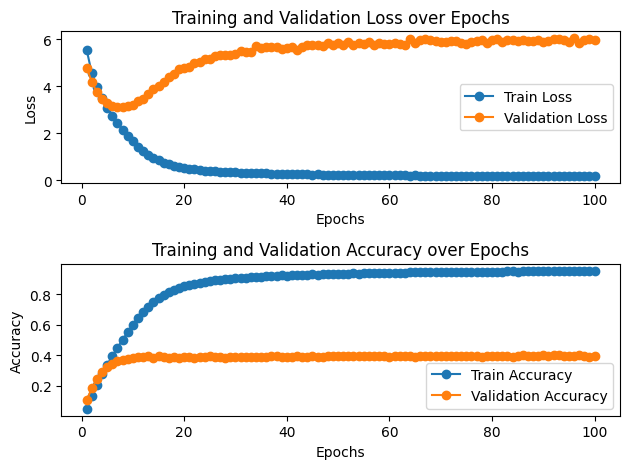

In [11]:
epochs = range(1, len(metrics["Train_loss"]) + 1)

#plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs, metrics["Train_loss"], label="Train Loss", marker='o')
plt.plot(epochs, metrics["Val_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, metrics["Train_acc"], label="Train Accuracy", marker='o')
plt.plot(epochs, metrics["Val_acc"], label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

**7.2** Test accuracy of VGG16 model

In [17]:
file_path = "/pfs/lustrep3/scratch/project_465001578/people/Complexmodel/vgg_whole_output/final_test_metrics.json"

with open(file_path, "r") as file:
    Testacc = json.load(file)
classification_report = Testacc['classification_report']

In [20]:
Testacc['accuracy']

0.4024770132453892

In [18]:
def get_metric(class_name, metric):
    if isinstance(classification_report[class_name], dict):
        return classification_report[class_name].get(metric, float('-inf'))  
    return float('-inf')  

top_10_precision = sorted(classification_report.items(), key=lambda x: get_metric(x[0], 'precision'), reverse=True)[:10]
top_10_recall = sorted(classification_report.items(), key=lambda x: get_metric(x[0], 'recall'), reverse=True)[:10]
top_10_f1_score = sorted(classification_report.items(), key=lambda x: get_metric(x[0], 'f1-score'), reverse=True)[:10]

print("Top 10 Classes by Precision:")
for i, (class_name, metrics) in enumerate(top_10_precision, 1):
    print(f"{i}. Class: {class_name}, Precision: {metrics['precision']}")
print("\nTop 10 Classes by Recall:")
for i, (class_name, metrics) in enumerate(top_10_recall, 1):
    print(f"{i}. Class: {class_name}, Recall: {metrics['recall']}")
print("\nTop 10 Classes by F1-score:")
for i, (class_name, metrics) in enumerate(top_10_f1_score, 1):
    print(f"{i}. Class: {class_name}, F1-score: {metrics['f1-score']}")

Top 10 Classes by Precision:
1. Class: Changeling (2008), Precision: 0.967741935483871
2. Class: Man on Fire (2004), Precision: 0.9532019704433498
3. Class: The Last of the Mohicans DDC (1992), Precision: 0.9142091152815014
4. Class: Babel (2006), Precision: 0.9129287598944591
5. Class: The Unforgivable (2021), Precision: 0.8938053097345132
6. Class: The Grand Budapest Hotel (2014), Precision: 0.8664850136239782
7. Class: Carnage (2011), Precision: 0.850609756097561
8. Class: Dr. Strangelove or How I Learned to Stop Worrying and Love the Bomb (1964), Precision: 0.84
9. Class: Before Sunset (2004), Precision: 0.8198757763975155
10. Class: The Breakfast Club (1985), Precision: 0.8161993769470405

Top 10 Classes by Recall:
1. Class: Changeling (2008), Recall: 0.9880239520958084
2. Class: Man on Fire (2004), Recall: 0.979746835443038
3. Class: Babel (2006), Recall: 0.9402173913043478
4. Class: The Last of the Mohicans DDC (1992), Recall: 0.9191374663072777
5. Class: The Unforgivable (2021)

In [19]:
def get_metric(class_name, metric):
    if isinstance(classification_report[class_name], dict):
        return classification_report[class_name].get(metric, float('inf')) 
    return float('inf') 

top_10_precision = sorted(classification_report.items(), key=lambda x: get_metric(x[0], 'precision'))[:10]
top_10_recall = sorted(classification_report.items(), key=lambda x: get_metric(x[0], 'recall'))[:10]
top_10_f1_score = sorted(classification_report.items(), key=lambda x: get_metric(x[0], 'f1-score'))[:10]

print("Bottom 10 Classes by Precision:")
for i, (class_name, metrics) in enumerate(top_10_precision, 1):
    print(f"{i}. Class: {class_name}, Precision: {metrics['precision']}")
print("\nBottom 10 Classes by Recall:")
for i, (class_name, metrics) in enumerate(top_10_recall, 1):
    print(f"{i}. Class: {class_name}, Recall: {metrics['recall']}")
print("\nBottom 10 Classes by F1-score:")
for i, (class_name, metrics) in enumerate(top_10_f1_score, 1):
    print(f"{i}. Class: {class_name}, F1-score: {metrics['f1-score']}")

Bottom 10 Classes by Precision:
1. Class: Kingdom Of Heaven (2005), Precision: 0.0425531914893617
2. Class: Face Off (1997), Precision: 0.10126582278481013
3. Class: The Adventures of Tintin (2011), Precision: 0.11343283582089553
4. Class: The Fugitive (1993), Precision: 0.11475409836065574
5. Class: The Incredibles (2004), Precision: 0.1266891891891892
6. Class: Captain America Civil War (2016), Precision: 0.14102564102564102
7. Class: The X Files (1998), Precision: 0.1462882096069869
8. Class: Elvis (2022), Precision: 0.14754098360655737
9. Class: Snowden (2016), Precision: 0.1553672316384181
10. Class: Coach Carter (2005), Precision: 0.15764705882352942

Bottom 10 Classes by Recall:
1. Class: The Adventures of Tintin (2011), Recall: 0.10410958904109589
2. Class: Face Off (1997), Recall: 0.11080332409972299
3. Class: Star Trek (2009), Recall: 0.12023460410557185
4. Class: Elvis (2022), Recall: 0.1226158038147139
5. Class: The Fugitive (1993), Recall: 0.1242603550295858
6. Class: Grin

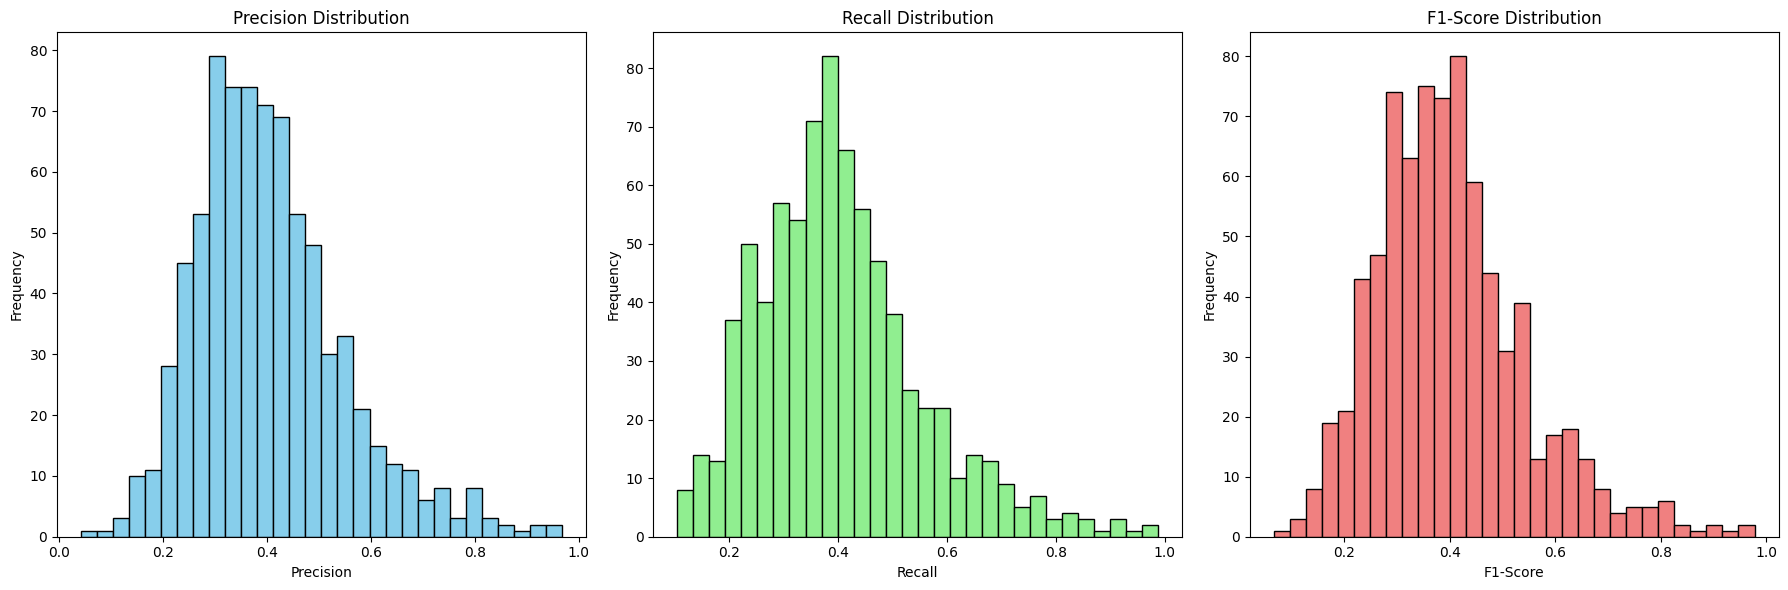

In [21]:
class_metrics = {class_name: metrics for class_name, metrics in classification_report.items() if isinstance(metrics, dict)}
precision_values = [metrics['precision'] for metrics in class_metrics.values()]
recall_values = [metrics['recall'] for metrics in class_metrics.values()]
f1_score_values = [metrics['f1-score'] for metrics in class_metrics.values()]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].hist(precision_values, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Precision Distribution')
axes[0].set_xlabel('Precision')
axes[0].set_ylabel('Frequency')

axes[1].hist(recall_values, bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title('Recall Distribution')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Frequency')

axes[2].hist(f1_score_values, bins=30, color='lightcoral', edgecolor='black')
axes[2].set_title('F1-Score Distribution')
axes[2].set_xlabel('F1-Score')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**7.3** The performance of ResNet50 model over 100 epochs

In [5]:
with open("/pfs/lustrep3/scratch/project_465001578/people/Resnet/resnet_whole2_output/Resnet_acc.txt", "r") as file:
    content = file.readlines()

metrics = {
    "Train_loss": [],
    "Train_acc": [],
    "Val_loss": [],
    "Val_acc": []
}

for line in content:
    if "Train Loss" in line or "Val Loss" in line:
        parts = line.strip().split(", ")
        for part in parts:
            label, value = part.split(": ")
            if "Train Loss" in label:
                metrics["Train_loss"].append(float(value))
            elif "Train Acc" in label:
                metrics["Train_acc"].append(float(value))
            elif "Val Loss" in label:
                metrics["Val_loss"].append(float(value))
            elif "Val Acc" in label:
                metrics["Val_acc"].append(float(value))

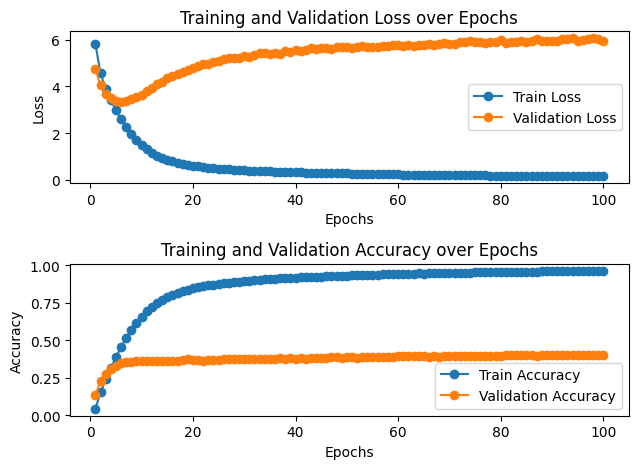

In [6]:
epochs = range(1, len(metrics["Train_loss"]) + 1)

#plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs, metrics["Train_loss"], label="Train Loss", marker='o')
plt.plot(epochs, metrics["Val_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, metrics["Train_acc"], label="Train Accuracy", marker='o')
plt.plot(epochs, metrics["Val_acc"], label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

**7.4** Test accuracy of ResNet50 model

In [7]:
file_path = "/pfs/lustrep3/scratch/project_465001578/people/Resnet/resnet_whole2_output/final_test_metrics.json"

with open(file_path, "r") as file:
    Testacc = json.load(file)
classification_report = Testacc['classification_report']

In [8]:
Testacc['accuracy']

0.40469951427598444

In [9]:
def get_metric(class_name, metric):
    if isinstance(classification_report[class_name], dict):
        return classification_report[class_name].get(metric, float('-inf'))  
    return float('-inf')  

top_10_precision = sorted(classification_report.items(), key=lambda x: get_metric(x[0], 'precision'), reverse=True)[:10]
top_10_recall = sorted(classification_report.items(), key=lambda x: get_metric(x[0], 'recall'), reverse=True)[:10]
top_10_f1_score = sorted(classification_report.items(), key=lambda x: get_metric(x[0], 'f1-score'), reverse=True)[:10]

print("Top 10 Classes by Precision:")
for i, (class_name, metrics) in enumerate(top_10_precision, 1):
    print(f"{i}. Class: {class_name}, Precision: {metrics['precision']}")
print("\nTop 10 Classes by Recall:")
for i, (class_name, metrics) in enumerate(top_10_recall, 1):
    print(f"{i}. Class: {class_name}, Recall: {metrics['recall']}")
print("\nTop 10 Classes by F1-score:")
for i, (class_name, metrics) in enumerate(top_10_f1_score, 1):
    print(f"{i}. Class: {class_name}, F1-score: {metrics['f1-score']}")

Top 10 Classes by Precision:
1. Class: Man on Fire (2004), Precision: 0.9796437659033079
2. Class: Changeling (2008), Precision: 0.9732142857142857
3. Class: Babel (2006), Precision: 0.9661971830985916
4. Class: Pi (1998), Precision: 0.9126506024096386
5. Class: Dr. Strangelove or How I Learned to Stop Worrying and Love the Bomb (1964), Precision: 0.9033232628398792
6. Class: The Grand Budapest Hotel (2014), Precision: 0.8994413407821229
7. Class: The Last of the Mohicans DDC (1992), Precision: 0.8963730569948186
8. Class: Buried (2010), Precision: 0.8940217391304348
9. Class: The Lighthouse (2019), Precision: 0.8635097493036211
10. Class: Locke (2013), Precision: 0.8588957055214724

Top 10 Classes by Recall:
1. Class: Changeling (2008), Recall: 0.9790419161676647
2. Class: Man on Fire (2004), Recall: 0.9746835443037974
3. Class: The Last of the Mohicans DDC (1992), Recall: 0.9326145552560647
4. Class: Babel (2006), Recall: 0.9320652173913043
5. Class: The Unforgivable (2021), Recall: 

In [10]:
def get_metric(class_name, metric):
    if isinstance(classification_report[class_name], dict):
        return classification_report[class_name].get(metric, float('inf')) 
    return float('inf') 

top_10_precision = sorted(classification_report.items(), key=lambda x: get_metric(x[0], 'precision'))[:10]
top_10_recall = sorted(classification_report.items(), key=lambda x: get_metric(x[0], 'recall'))[:10]
top_10_f1_score = sorted(classification_report.items(), key=lambda x: get_metric(x[0], 'f1-score'))[:10]

print("Bottom 10 Classes by Precision:")
for i, (class_name, metrics) in enumerate(top_10_precision, 1):
    print(f"{i}. Class: {class_name}, Precision: {metrics['precision']}")
print("\nBottom 10 Classes by Recall:")
for i, (class_name, metrics) in enumerate(top_10_recall, 1):
    print(f"{i}. Class: {class_name}, Recall: {metrics['recall']}")
print("\nBottom 10 Classes by F1-score:")
for i, (class_name, metrics) in enumerate(top_10_f1_score, 1):
    print(f"{i}. Class: {class_name}, F1-score: {metrics['f1-score']}")

Bottom 10 Classes by Precision:
1. Class: The Fugitive (1993), Precision: 0.09125475285171103
2. Class: The Way Way Back (2013), Precision: 0.09972677595628415
3. Class: X Men Days of Future Past (2014), Precision: 0.11387163561076605
4. Class: X Men First Class (2011), Precision: 0.11823647294589178
5. Class: Elvis (2022), Precision: 0.11965811965811966
6. Class: Captain America Civil War (2016), Precision: 0.1276595744680851
7. Class: The Incredibles (2004), Precision: 0.13414634146341464
8. Class: Star Trek (2009), Precision: 0.14052287581699346
9. Class: X-Men 2 (2003), Precision: 0.14114832535885166
10. Class: Patriots Day (2016), Precision: 0.1417004048582996

Bottom 10 Classes by Recall:
1. Class: Elvis (2022), Recall: 0.11444141689373297
2. Class: Face Off (1997), Recall: 0.12465373961218837
3. Class: Star Trek (2009), Recall: 0.12609970674486803
4. Class: The Fugitive (1993), Recall: 0.14201183431952663
5. Class: Donnie Brasco (1997), Recall: 0.14361702127659576
6. Class: Blac

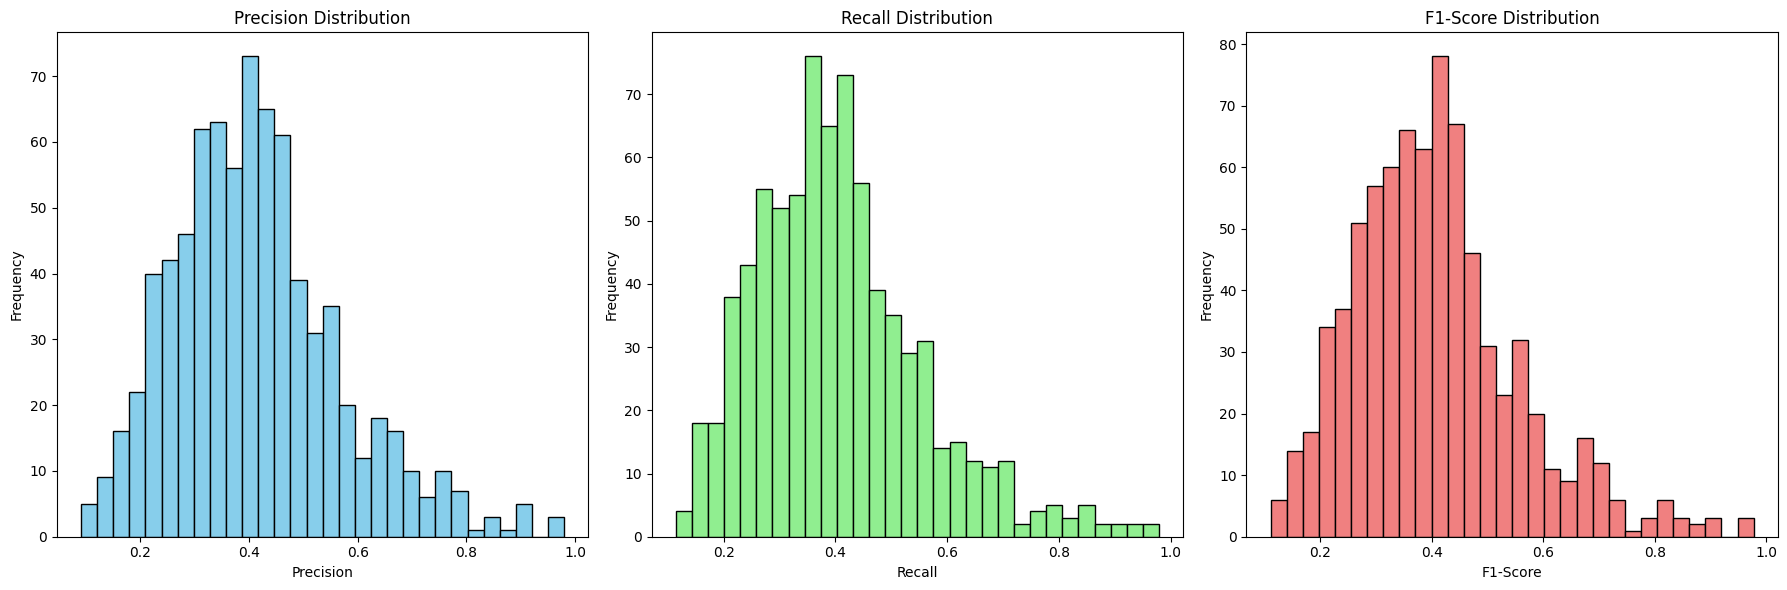

In [11]:
class_metrics = {class_name: metrics for class_name, metrics in classification_report.items() if isinstance(metrics, dict)}
precision_values = [metrics['precision'] for metrics in class_metrics.values()]
recall_values = [metrics['recall'] for metrics in class_metrics.values()]
f1_score_values = [metrics['f1-score'] for metrics in class_metrics.values()]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].hist(precision_values, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Precision Distribution')
axes[0].set_xlabel('Precision')
axes[0].set_ylabel('Frequency')

axes[1].hist(recall_values, bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title('Recall Distribution')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Frequency')

axes[2].hist(f1_score_values, bins=30, color='lightcoral', edgecolor='black')
axes[2].set_title('F1-Score Distribution')
axes[2].set_xlabel('F1-Score')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()